In [1]:
from sentiment import *

In [2]:
print("Reading data")
tarfname = "data/sentiment.tar.gz"
sentiment = read_files(tarfname)

Reading data
-- train data
sentiment/train.tsv
4582
-- dev data
sentiment/dev.tsv
458
-- transforming data and labels


In [3]:
print("\nReading unlabeled data")
unlabeled = read_unlabeled(tarfname, sentiment)


Reading unlabeled data
sentiment/unlabeled.tsv
(91524, 175067)


In [4]:
print("\nTraining classifier")
import classify
cls = classify.train_classifier(sentiment.trainX, sentiment.trainy)
print("\nEvaluating")
classify.evaluate(sentiment.trainX, sentiment.trainy, cls, 'train')
classify.evaluate(sentiment.devX, sentiment.devy, cls, 'dev')



Training classifier

Evaluating
  Accuracy on train  is: 1.0
  Accuracy on dev  is: 0.8275109170305677


0.8275109170305677

### ambugious feature pruning

In [97]:
from nltk.util import ngrams
list(ngrams(sentiment.train_data_corr[0], 1))[0][0] in sentiment.count_vect.vocabulary_

True

In [111]:
from collections import defaultdict
word_frequencies = defaultdict(lambda: defaultdict(int))
for tokens, label in zip(sentiment.train_data_corr, sentiment.train_labels):
    for token in tokens:
        if token in sentiment.count_vect.vocabulary_:
            word_frequencies[label][token] += 1
        else:
            print(token)
    for ngram in [2, 3]:
        for token in ngrams(tokens, ngram):
            join_token = ' '.join(token)
            if join_token in sentiment.count_vect.vocabulary_:
                word_frequencies[label][join_token] += 1
            else:
                # shouldn't be any exceptions
                print(join_token)

In [154]:
fuzzy_tokens = []
for token in word_frequencies['POSITIVE']:
    if token in word_frequencies['NEGATIVE']:
        if abs(word_frequencies['POSITIVE'][token] - word_frequencies['NEGATIVE'][token]) / (word_frequencies['POSITIVE'][token] + word_frequencies['NEGATIVE'][token]) < 0.5:
            fuzzy_tokens.append(token)

In [161]:
sentiment_ = deepcopy(sentiment)

In [162]:
print(len(sentiment_.count_vect.vocabulary_))
for token in fuzzy_tokens:
    sentiment_.count_vect.vocabulary_.pop(token)
print(len(sentiment_.count_vect.vocabulary_))

175067
160056


In [264]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1,3),
                     lowercase=False,
                     tokenizer=lambda l: l)
cv.fit(sentiment_.train_data_corr)
print(len(cv.vocabulary_))

175067


In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer
sentiment_.count_vect = TfidfVectorizer(ngram_range=(1,3),
                                       norm=None,
                                       sublinear_tf=True,
                                       stop_words=[],
                                       lowercase=False,
                                       tokenizer=lambda l: l,
                                       vocabulary=sentiment_.count_vect.vocabulary_.keys())

In [169]:
sentiment_.trainX = sentiment_.count_vect.fit_transform(sentiment_.train_data_corr)
print(len(sentiment_.count_vect.vocabulary_))

print(len(sentiment.count_vect.vocabulary_))
cls = classify.train_classifier(sentiment.trainX, sentiment.trainy)
classify.evaluate(sentiment.trainX, sentiment.trainy, cls, 'train')
classify.evaluate(sentiment.devX, sentiment.devy, cls, 'dev')

cls = classify.train_classifier(sentiment_.trainX, sentiment_.trainy)
sentiment_.devX = sentiment_.count_vect.transform(sentiment_.dev_data_corr)
classify.evaluate(sentiment_.trainX, sentiment_.trainy, cls, 'train')
classify.evaluate(sentiment_.devX, sentiment_.devy, cls, 'dev')


160056
175067
  Accuracy on train  is: 1.0
  Accuracy on dev  is: 0.8275109170305677
  Accuracy on train  is: 1.0
  Accuracy on dev  is: 0.8100436681222707


### ensemble

In [266]:
cv = CountVectorizer(ngram_range=(1,3),
                     lowercase=False,
                     tokenizer=lambda l: l)
cv.fit(unlabeled.data_corr)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x1a3fd6fd90>, vocabulary=None)

In [276]:
print(len(cv.vocabulary_))
print(len(sentiment.count_vect.vocabulary_))

1914730
175067


In [281]:
type(list(sentiment.count_vect.vocabulary_.keys()))

list

In [269]:
len([k for k in cv.vocabulary_ if k not in sentiment.count_vect.vocabulary_])

1813970

In [284]:
import random
# unlabels_features = [k for k in cv.vocabulary_ if k not in sentiment.count_vect.vocabulary_]
unlabels_features = list(cv.vocabulary_.keys())
random.shuffle(unlabels_features)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizers = []
for i in range(10):
    pace = round(len(unlabels_features) / 10)
    # vocabulary_new = list(sentiment.count_vect.vocabulary_.keys())
    vocabulary_new = unlabels_features[pace*i:max(pace*(i+1), len(unlabels_features))]
    vectorizers.append(TfidfVectorizer(ngram_range=(1,3),
                                       norm=None,
                                       sublinear_tf=True,
                                       stop_words=[],
                                       lowercase=False,
                                       tokenizer=lambda l: l,
                                       vocabulary=vocabulary_new))

In [287]:
preds = []
for i, vectorizer in enumerate(vectorizers):
    print(i)
    train_data = vectorizer.fit_transform(sentiment.train_data_corr)
    unlabeled_data = vectorizer.transform(unlabeled.data_corr)
    cls = classify.train_classifier(train_data, sentiment.trainy)
    preds.append(cls.predict(unlabeled_data))

0
1
2
3
4
5
6
7
8
9


In [310]:
sum(cls.predict(train_data)== sentiment.trainy) / len(sentiment.trainy)

0.9954168485377565

In [311]:
devX = vectorizers[-1].transform(sentiment.dev_data_corr)
classify.evaluate(devX, sentiment_copy.devy, cls, 'dev')

  Accuracy on dev  is: 0.6157205240174672


In [293]:
agree_inds = set(range(len(preds[0])))
for ind, (pred1, pred2) in enumerate(zip(preds[:-1], preds[1:])):
    print(ind)
    agree_inds = agree_inds.intersection(set(np.where(pred1 == pred2)[0]))

0
1
2
3
4
5
6
7
8


In [296]:
print(len(preds[0]))
len(agree_inds)

91524


47743

In [298]:
len(agree_inds.intersection(set(confident_ind)))

2076

### soft-labels 1% unlabeled data

In [97]:
from copy import deepcopy

In [98]:
unlabeled_copy = deepcopy(unlabeled)
sentiment_copy = deepcopy(sentiment)

In [144]:
accuracies_1 = []
# threshes = [0.99999, 0.9999, 0.999, 0.99]
num_added_1 = []
threshes = [0.9999]

for thresh in threshes:
    # deey copy
    print('copying')
    unlabeled_copy = deepcopy(unlabeled)
    sentiment_copy = deepcopy(sentiment)

    print('--------th %g ' % thresh)
    i = 0
    # confident_ind = [1]
    confident_inds = []
    confident_pos = 0
    confident_neg = 0
    while True:
        i += 1
        print('round -', i)
        # train
        cls = classify.train_classifier(sentiment_copy.trainX, sentiment_copy.trainy)
        confident_ind = np.where(np.max(cls.predict_proba(unlabeled_copy.X), axis=1) > thresh)[0]
    #     pred_probas = cls.predict_proba(unlabeled_copy.X)
    #     confident_ind_pos = np.argsort(pred_probas[:,1])[::-1][:1000]
    #     confident_ind_neg = np.argsort(pred_probas[:,0])[::-1][:1000]
    #     confident_ind = np.concatenate((confident_ind_pos, confident_ind_neg))
        if len(confident_ind) == 0 or i>5:
            break
        confident_inds.append(confident_ind)

        predictions_unlabeled_conf = cls.predict(unlabeled_copy.X)[confident_ind]
        print(len(confident_ind))
        confident_pos += sum(predictions_unlabeled_conf == 1)
        confident_neg += sum(predictions_unlabeled_conf == 0)
        print('pos:', sum(predictions_unlabeled_conf == 1))
        print('neg:', sum(predictions_unlabeled_conf == 0))

        # expand train data
        sentiment_copy.trainy = np.concatenate((sentiment_copy.trainy,
                                                predictions_unlabeled_conf))
        # print(len(sentiment_copy.train_data_corr))
        sentiment_copy.train_data_corr.extend([unlabeled_copy.data_corr[i] for i in confident_ind])
        # print(len(sentiment_copy.train_data_corr))

        # remove selected data from unlabeled
        unlabeled_copy.data_corr = [unlabeled_copy.data_corr[i] for i in range(len(unlabeled_copy.data_corr)) if i not in confident_ind]
        if len(unlabeled_copy.data_corr) == 0: break
        # print(len(unlabeled_copy.data_corr))


        # rebuild features
        sentiment_copy.trainX = sentiment_copy.count_vect.fit_transform(sentiment_copy.train_data_corr)
        unlabeled_copy.X = sentiment_copy.count_vect.transform(unlabeled_copy.data_corr)
        sentiment_copy.devX = sentiment_copy.count_vect.transform(sentiment_copy.dev_data_corr)
        cls = classify.train_classifier(sentiment_copy.trainX,
                                        sentiment_copy.trainy)
        classify.evaluate(sentiment_copy.devX, sentiment_copy.devy, cls, 'dev')

    num_added_1.append((len(confident_inds), confident_pos, confident_neg))
    cls = classify.train_classifier(sentiment_copy.trainX,
                                    sentiment_copy.trainy)
    classify.evaluate(sentiment_copy.devX, sentiment_copy.devy, cls, 'dev')
    accuracies_1.append(metrics.accuracy_score(sentiment_copy.devy, 
                                               cls.predict(sentiment_copy.devX)))

copying
--------th 0.9999 
round - 1
2324
pos: 1664
neg: 660
  Accuracy on dev  is: 0.8144104803493449
round - 2
39
pos: 20
neg: 19
  Accuracy on dev  is: 0.8122270742358079
round - 3
4
pos: 3
neg: 1
  Accuracy on dev  is: 0.8122270742358079
round - 4
  Accuracy on dev  is: 0.8122270742358079


NameError: name 'metrics' is not defined

In [143]:
acc = [0.8275109170305677, 0.8209606986899564, 0.8122270742358079, 0.7969432314410481, 0.7816593886462883]

In [153]:
threshes

[0.99999, 0.9999, 0.999, 0.99]

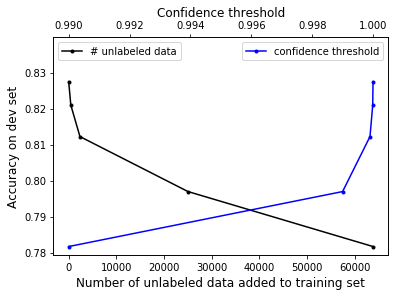

In [195]:
_, pos, neg = zip(*num_added_1)
fig, ax = plt.subplots()
ax.plot([0]+[p+n for p, n in zip(pos,neg)], [0.8275109170305677]+accuracies_1, 'k.-', label="# unlabeled data")
ax1=ax.twiny()
ax1.plot([1]+threshes, [0.8275109170305677]+accuracies_1, 'b.-', label="confidence threshold")
# ax1.set_xscale('log')
ax.legend(loc="upper left", fontsize=10)
ax1.legend(loc="upper right", fontsize=10)
ax.set_xlabel("Number of unlabeled data added to training set", fontsize=12)
ax1.set_xlabel("Confidence threshold", fontsize=12)
ax.set_ylabel("Accuracy on dev set", fontsize=12)
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]+0.01))
plt.savefig("report/img/thresh.png")

In [155]:
from sklearn import metrics

In [166]:
accuracies = []
labeled_sizes = [1.0, 0.8, 0.6, 0.4, 0.2]
num_added = []
thresh = 0.9999

for size in labeled_sizes:
    # deey copy
    print('copying')
    unlabeled_copy = deepcopy(unlabeled)
    sentiment_copy = deepcopy(sentiment)
    up = round(size*len(sentiment_copy.train_data_corr))
    sentiment_copy.trainX = sentiment_copy.trainX[:up]
    sentiment_copy.trainy = sentiment_copy.trainy[:up]
    sentiment_copy.train_data_corr = sentiment_copy.train_data_corr[:up]

    print('--------size %g ' % up)
    i = 0
    # confident_ind = [1]
    confident_inds = []
    confident_pos = 0
    confident_neg = 0
    while True:
        i += 1
        print('round -', i)
        # train
        cls = classify.train_classifier(sentiment_copy.trainX, sentiment_copy.trainy)
        confident_ind = np.where(np.max(cls.predict_proba(unlabeled_copy.X), axis=1) > thresh)[0]
    #     pred_probas = cls.predict_proba(unlabeled_copy.X)
    #     confident_ind_pos = np.argsort(pred_probas[:,1])[::-1][:1000]
    #     confident_ind_neg = np.argsort(pred_probas[:,0])[::-1][:1000]
    #     confident_ind = np.concatenate((confident_ind_pos, confident_ind_neg))
        if len(confident_ind) == 0 or i>5:
            break
        confident_inds.append(confident_ind)

        predictions_unlabeled_conf = cls.predict(unlabeled_copy.X)[confident_ind]
        print(len(confident_ind))
        confident_pos += sum(predictions_unlabeled_conf == 1)
        confident_neg += sum(predictions_unlabeled_conf == 0)
        print('pos:', sum(predictions_unlabeled_conf == 1))
        print('neg:', sum(predictions_unlabeled_conf == 0))

        # expand train data
        sentiment_copy.trainy = np.concatenate((sentiment_copy.trainy,
                                                predictions_unlabeled_conf))
        # print(len(sentiment_copy.train_data_corr))
        sentiment_copy.train_data_corr.extend([unlabeled_copy.data_corr[i] for i in confident_ind])
        # print(len(sentiment_copy.train_data_corr))

        # remove selected data from unlabeled
        unlabeled_copy.data_corr = [unlabeled_copy.data_corr[i] for i in range(len(unlabeled_copy.data_corr)) if i not in confident_ind]
        if len(unlabeled_copy.data_corr) == 0: break
        # print(len(unlabeled_copy.data_corr))


        # rebuild features
        sentiment_copy.trainX = sentiment_copy.count_vect.fit_transform(sentiment_copy.train_data_corr)
        unlabeled_copy.X = sentiment_copy.count_vect.transform(unlabeled_copy.data_corr)
        sentiment_copy.devX = sentiment_copy.count_vect.transform(sentiment_copy.dev_data_corr)

    num_added.append((len(confident_inds), confident_pos, confident_neg))
    cls = classify.train_classifier(sentiment_copy.trainX,
                                    sentiment_copy.trainy)
    classify.evaluate(sentiment_copy.devX, sentiment_copy.devy, cls, 'dev')
    accuracies.append(metrics.accuracy_score(sentiment_copy.devy, 
                                             cls.predict(sentiment_copy.devX)))

copying
--------size 4582 
round - 1
2324
pos: 1664
neg: 660
round - 2
39
pos: 20
neg: 19
round - 3
4
pos: 3
neg: 1
round - 4
  Accuracy on dev  is: 0.8122270742358079
copying
--------size 3666 
round - 1
1519
pos: 1166
neg: 353
round - 2
32
pos: 14
neg: 18
round - 3
4
pos: 0
neg: 4
round - 4
2
pos: 1
neg: 1
round - 5
  Accuracy on dev  is: 0.8122270742358079
copying
--------size 2749 
round - 1
731
pos: 576
neg: 155
round - 2
46
pos: 15
neg: 31
round - 3
4
pos: 3
neg: 1
round - 4
1
pos: 0
neg: 1
round - 5
  Accuracy on dev  is: 0.7903930131004366
copying
--------size 1833 
round - 1
148
pos: 124
neg: 24
round - 2
31
pos: 13
neg: 18
round - 3
  Accuracy on dev  is: 0.7685589519650655
copying
--------size 916 
round - 1
  Accuracy on dev  is: 0.7532751091703057


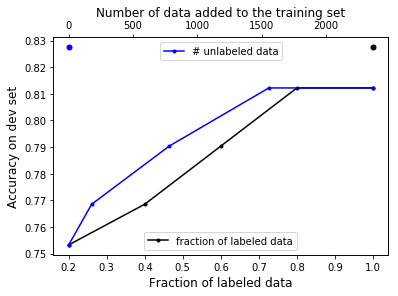

In [194]:
_, pos, neg = zip(*num_added)
fig, ax = plt.subplots()
ax.plot(labeled_sizes, accuracies, 'k.-', label="fraction of labeled data")
ax.plot(1, 0.8275109170305677, 'k.', markersize=10)
ax1=ax.twiny()
ax1.plot([p+n for p, n in zip(pos,neg)], accuracies, 'b.-', label="# unlabeled data")
ax1.plot(0, 0.8275109170305677, 'b.', markersize=10)
# ax1.set_xscale('log')
ax.legend(loc="lower center", fontsize=10)
ax1.legend(loc="upper center", fontsize=10)
ax.set_xlabel('Fraction of labeled data', fontsize=12)
ax1.set_xlabel('Number of data added to the training set', fontsize=12)
ax.set_ylabel('Accuracy on dev set', fontsize=12)
plt.savefig('report/img/labeled-size.png')

In [164]:
labeled_sizes

[1.0, 0.8, 0.6, 0.4, 0.5]

In [ ]:
2367

In [11]:
# write to kaggle
unlabeled_copy.X = sentiment_copy.count_vect.transform(unlabeled.data_corr)
write_pred_kaggle_file(unlabeled_copy, cls, "data/sentiment-pred.csv", sentiment_copy)

In [42]:
np.concatenate((confident_ind_pos, np.arange(10)))

array([24192, 47695, 17862, ...,     7,     8,     9])

In [90]:
print(len(sentiment_copy.count_vect.vocabulary_))
print(len(sentiment.count_vect.vocabulary_))
print((len(sentiment_copy.count_vect.vocabulary_)-len(sentiment.count_vect.vocabulary_))/len(sentiment.count_vect.vocabulary_))

230650
175067
0.3174955874036797


In [9]:
cls = classify.train_classifier(sentiment_copy.trainX,
                                sentiment_copy.trainy)
classify.evaluate(sentiment_copy.trainX, sentiment_copy.trainy, cls, 'train')
classify.evaluate(sentiment_copy.devX, sentiment_copy.devy, cls, 'dev')

  Accuracy on train  is: 1.0
  Accuracy on dev  is: 0.8122270742358079


In [10]:
cls_orig = classify.train_classifier(sentiment.trainX, sentiment.trainy)
classify.evaluate(sentiment.trainX, sentiment.trainy, cls_orig, 'train')
classify.evaluate(sentiment.devX, sentiment.devy, cls_orig, 'dev')

  Accuracy on train  is: 1.0
  Accuracy on dev  is: 0.8275109170305677


In [231]:
sentiment_copy.trainX != sentiment_val_copy.trainX

True

In [61]:
disagree = np.where(cls_orig.predict(sentiment.devX) != cls.predict(sentiment_copy.devX))[0]
print(disagree)
print(cls_orig.predict(sentiment.devX)[disagree])
print(cls_orig.predict_proba(sentiment.devX)[disagree][:,1])
print(cls.predict(sentiment_copy.devX)[disagree])
print(cls.predict_proba(sentiment_copy.devX)[disagree][:,1])
print(sentiment.devy[disagree])
print(sentiment_copy.devy[disagree])
for i in disagree:
    print(sentiment.dev_data[i], end='\n----\n')
#     print(sentiment.devX[i])
#     print()
#     print(sentiment_copy.devX[i])

[ 33  73  92 122 163 173 316 346 432]
[0 0 0 0 0 0 1 0 0]
[0.47609486 0.47679149 0.48080411 0.47802131 0.49342601 0.39665612
 0.52241037 0.47933408 0.45198565]
[1 1 1 1 1 1 0 1 1]
[0.5235327  0.5591133  0.5353925  0.508808   0.51558383 0.50168251
 0.47824288 0.51572978 0.50174885]
[0 0 0 0 1 0 1 0 0]
[0 0 0 0 1 0 1 0 0]
Located inside the Planet Hollywood near the gaming.Drinks and service was on point but the price was not.One iced, one hot coffee and two pastries= $22!!Now I know why there
----
This Sonic had good food (for a Sonic) but service was very slow.Be advised that they use fake whipped cream as a topping on their shakes and (presumably) ice cream.
----
Wow, what a disappointment! The boyfriend and I were celebrating out anniversary by staying at the Pointe and decided to try this place for dinner on a Saturday night. At
----
I usually go to the Lennys on 35th and thunderbird, but this one was closer to my house. It was my first time going to this lennys and i must
----
It's

actually the new classifier got one right

In [62]:
disagree_ind = 73

In [67]:
inverse_vocab = dict([(v,k) for k,v in sentiment.count_vect.vocabulary_.items()])
s = 0
c = 0
for ind in sentiment.devX[disagree_ind].indices:
    print(inverse_vocab[ind], sentiment.devX[disagree_ind][(0,ind)], cls_orig.coef_[0,ind])
    s += sentiment.devX[disagree_ind][(0,ind)] * cls_orig.coef_[0,ind]
    c += 1
print(c)
print(s)
print(cls_orig.intercept_)
print(s + cls_orig.intercept_)

whipped cream 8.331496795841014 0.008979938484241492
whipped 8.331496795841014 0.008979938484241492
wa very 4.941472714776984 0.031860422049284555
wa 2.0630320246281117 -0.1421483138615925
very 3.2316303680168157 0.11241897029705532
use 5.579961482799066 -0.01670916251498555
topping 7.127523991515078 0.00456404898332678
this 2.112896676149285 -0.0634488244443215
they use 7.4841989354538105 0.016504375546491555
they 2.750509898664741 -0.16539028928801006
their 3.7671486043731783 -0.0131802301801974
that they use 8.73696190394918 -0.008565973368126353
that they 5.903748559892962 -0.010852625043343894
that 2.787622283141868 -0.04040347224027161
sonic 14.792962414331205 0.00793566588430875
shake and 8.73696190394918 0.010666562505784183
shake 7.032213811710753 0.030918336873138472
service wa very 7.032213811710753 0.06567504335354374
service wa 4.570296680147452 -0.02492127402266395
service 2.9318269350326904 -0.11418307560349367
on their 6.485670105342684 0.02574357419738456
on 2.70868338

In [68]:
inverse_vocab = dict([(v,k) for k,v in sentiment_copy.count_vect.vocabulary_.items()])
s = 0
c = 0
for ind in sentiment_copy.devX[disagree_ind].indices:
    print(inverse_vocab[ind], sentiment_copy.devX[disagree_ind][(0,ind)], cls.coef_[0,ind])
    s += sentiment_copy.devX[disagree_ind][(0,ind)] * cls.coef_[0,ind]
    c += 1
print(c)
print(s)
print(cls.intercept_)
print(s + cls.intercept_)

whipped cream 8.747884649890729 0.008981685913738881
whipped 8.747884649890729 0.008981685913738881
wa very 4.8628903168505015 0.03263425474420407
wa 2.0885907302070907 -0.14847226379628278
very 3.0385619948589118 0.13025739618174095
use 5.626989233382731 -0.018524469815243708
topping 7.073908216319056 0.007078296601239802
this 2.0365498520820475 -0.054223582513116535
they use 7.649272361222619 0.015462916849680397
they 2.6911006366621035 -0.16076612546893715
their 3.7619975254836664 -0.007453087356088284
that they use 8.747884649890729 -0.0076971263127754855
that they 5.857512891994563 -0.010426264193132966
that 2.936743656914028 -0.04484930245446798
sonic 14.324368140956736 0.006410892400513788
shake and 9.153349757998892 0.010435202767081413
shake 7.138446737456627 0.029965112613250258
service wa very 7.281547581097301 0.06466962820041477
service wa 4.285815307543309 -0.029536593037851347
service 2.6159337851495454 -0.11374419784410479
on their 6.550660072554509 0.02259708883023553


In [82]:
print(sentiment_copy.count_vect.transform([['good']]))
print(sentiment.count_vect.transform([['good']]).indices[0])

  (0, 94172)	2.9702323266680715
70268


In [110]:
# inverse_vocab = dict([(v,k) for k,v in sentiment_copy.count_vect.vocabulary_.items()])
sentiment_copy.count_vect.idf_[sentiment_copy.count_vect.vocabulary_['owned']]
sentiment_copy.count_vect.idf_[sentiment_copy.count_vect.vocabulary_['chile']]

7.767055396879002

In [100]:
tfidfs = []
for token in sentiment.count_vect.vocabulary_:
    if len(token.split()) == 1:
        ind = sentiment.count_vect.transform([[token]]).indices[0]
        t_sup = sentiment.count_vect.transform([[token]])[0,ind]
        ind = sentiment_copy.count_vect.transform([[token]]).indices[0]
        t_semi = sentiment_copy.count_vect.transform([[token]])[0,ind]
        tfidfs.append((token, t_sup, t_semi))

In [118]:
for t, t_sup, t_semi in sorted(tfidfs, key=lambda x: abs(x[1]-x[2]))[::-1][:40]:
    print('%s & %.4f & %.4f \\\\ ' % (t, t_sup, t_semi))

owned & 8.3315 & 7.0133 \\ 
chile & 8.7370 & 7.7671 \\ 
pesto & 8.3315 & 7.3616 \\ 
delicious & 4.5549 & 3.6853 \\ 
refund & 8.7370 & 7.9006 \\ 
support & 8.7370 & 7.9006 \\ 
thick & 8.7370 & 7.9006 \\ 
tofu & 8.7370 & 7.9006 \\ 
environment & 7.2329 & 6.4125 \\ 
amazing & 4.3181 & 3.4991 \\ 
favourite & 4.8451 & 4.0535 \\ 
personable & 7.6383 & 6.8508 \\ 
homemade & 7.3507 & 6.5884 \\ 
friendly & 4.1120 & 3.3850 \\ 
chopped & 8.7370 & 8.0547 \\ 
lash & 8.7370 & 8.0547 \\ 
nikki & 8.7370 & 8.0547 \\ 
al & 8.7370 & 8.0547 \\ 
cobb & 8.7370 & 8.0547 \\ 
tiffany & 8.7370 & 8.0547 \\ 
matt & 8.7370 & 8.0547 \\ 
scratch & 8.7370 & 8.0547 \\ 
amy & 8.7370 & 8.0547 \\ 
1.5 & 8.7370 & 8.0547 \\ 
refused & 8.7370 & 8.0547 \\ 
patron & 8.7370 & 8.0547 \\ 
atmosphere & 4.8975 & 4.2153 \\ 
chat & 8.3315 & 7.6493 \\ 
ravioli & 8.3315 & 7.6493 \\ 
build & 8.3315 & 7.6493 \\ 
sashimi & 8.3315 & 7.6493 \\ 
skill & 8.3315 & 7.6493 \\ 
kimchi & 8.3315 & 7.6493 \\ 
yummy & 6.2112 & 5.5698 \\ 
knowledgeab

In [123]:
coeffs = []
for token in sentiment.count_vect.vocabulary_:
    if len(token.split()) == 1:
        ind_semi = sentiment_copy.count_vect.vocabulary_[token]
        ind_sup = sentiment.count_vect.vocabulary_[token]
        coeffs.append((token, cls.coef_[0, ind_semi], cls_orig.coef_[0, ind_sup]))
for t, t_sup, t_semi in sorted(coeffs, key=lambda x: abs(x[1]-x[2]))[::-1][:40]:
    print('%s & %.4f & %.4f \\\\ ' % (t, t_sup, t_semi))

! & 0.4301 & 0.3780 \\ 
ever & -0.1018 & -0.0688 \\ 
great & 0.5419 & 0.5102 \\ 
and & 0.2320 & 0.2069 \\ 
is & 0.0946 & 0.0701 \\ 
love & 0.3056 & 0.2821 \\ 
best & 0.3506 & 0.3311 \\ 
are & 0.0323 & 0.0130 \\ 
worst & -0.4646 & -0.4464 \\ 
very & 0.1303 & 0.1124 \\ 
staff & 0.1220 & 0.1055 \\ 
no & -0.1831 & -0.1668 \\ 
not & -0.4120 & -0.3959 \\ 
friendly & 0.2218 & 0.2071 \\ 
the & -0.0146 & -0.0291 \\ 
place & 0.0512 & 0.0367 \\ 
food & -0.0658 & -0.0798 \\ 
atmosphere & 0.0814 & 0.0679 \\ 
star & -0.1218 & -0.1099 \\ 
always & 0.1698 & 0.1582 \\ 
fresh & 0.1010 & 0.0895 \\ 
give & -0.0501 & -0.0387 \\ 
, & 0.0626 & 0.0518 \\ 
closed & -0.1731 & -0.1630 \\ 
super & 0.0336 & 0.0240 \\ 
to & -0.1416 & -0.1323 \\ 
do & -0.1202 & -0.1109 \\ 
like & -0.1037 & -0.0944 \\ 
this & -0.0542 & -0.0634 \\ 
at & -0.0499 & -0.0406 \\ 
took & -0.0215 & -0.0125 \\ 
coffee & 0.0601 & 0.0512 \\ 
bad & -0.2268 & -0.2181 \\ 
pizza & 0.0257 & 0.0170 \\ 
owner & 0.0265 & 0.0179 \\ 
my & 0.0918 & 0.0832

In [16]:
print(sentiment.dev_data[disagree_ind])
set_orig = sentiment.count_vect.inverse_transform(sentiment.devX[disagree_ind])[0]
set_new = sentiment_copy.count_vect.inverse_transform(sentiment_copy.devX[disagree_ind])[0]
print([w for w in set_new if w not in set_orig])

Wow, what a disappointment! The boyfriend and I were celebrating out anniversary by staying at the Pointe and decided to try this place for dinner on a Saturday night. At
['the boyfriend and', 'the boyfriend', 'place for dinner', 'dinner on', '! the boyfriend']


In [18]:
unlabeled_predictions = np.vstack((cls_orig.predict_proba(unlabeled.X)[:,1],
                    cls.predict_proba(sentiment_copy.count_vect.transform(unlabeled.data_corr))[:,1])).T

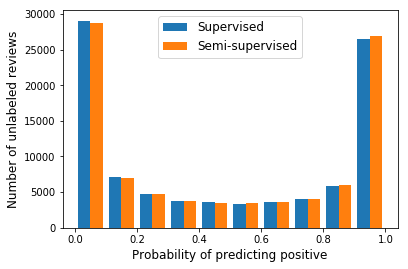

In [28]:
import matplotlib.pyplot as plt
# plt.hist(np.vstack((cls_orig.predict_proba(sentiment.devX)[:,1],
#                     cls.predict_proba(sentiment_copy.devX)[:,1])).T)
# # plt.legend()
plt.hist(unlabeled_predictions, label=['Supervised', 'Semi-supervised'])
fontsize=12
plt.legend(fontsize=fontsize)
# plt.yscale('log')
plt.xlabel('Probability of predicting positive', fontsize=fontsize)
plt.ylabel('Number of unlabeled reviews', fontsize=fontsize)
plt.savefig('report/img/positive-tendency.png')

In [43]:
pred_semi = cls.predict(sentiment_copy.count_vect.transform(unlabeled.data_corr))
pred_sup = cls_orig.predict(unlabeled.X)

(91524, 2)
(1141, 2)


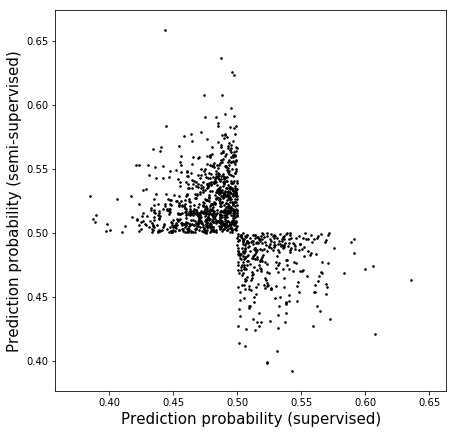

In [59]:
disagree_probs = unlabeled_predictions[np.where(pred_semi!=pred_sup)[0]]
print(unlabeled_predictions.shape)
print(disagree_probs.shape)
fig = plt.figure(figsize=(7,7))
plt.scatter(disagree_probs[:,0], disagree_probs[:,1], 10, marker='.', c='k')
plt.axis('equal')
plt.xlabel('Prediction probability (supervised)', fontsize=15)
plt.ylabel('Prediction probability (semi-supervised)', fontsize=15)
plt.savefig('report/img/disagree.png')

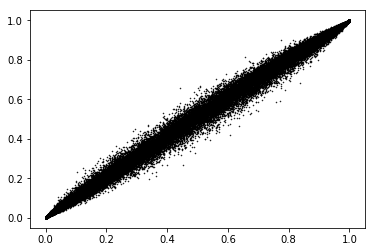

In [60]:
plt.scatter(unlabeled_predictions[:,0], unlabeled_predictions[:,1], 1, marker='.', c='k')

become more positive overall

e.g.
0 0 0 0 0 --> 1 1 1 1 (see before)

In [17]:
cls.predict_proba(sentiment_copy.trainX)

array([[2.35125824e-03, 9.97648742e-01],
       [1.15423319e-03, 9.98845767e-01],
       [9.98913127e-01, 1.08687348e-03],
       ...,
       [5.53981243e-05, 9.99944602e-01],
       [9.99997838e-01, 2.16187689e-06],
       [9.99909877e-01, 9.01230560e-05]])

In [21]:
cls.predict_proba(sentiment_copy.trainX).shape
cls_orig.predict_proba(sentiment.trainX).shape

(4582, 2)

show some most positive words (by compare frequency)
and their driven tfidf and weights

In [48]:
unlabeled.data[confident_ind[0]]

'Delicious gyros, excellent tzatziki. Amazing baklava. Definitely my new lunch spot. Mona is great she takes good care of her customers. Very clean, nice aroma, very friendly staff. This is'

In [49]:
sum(cls_orig.predict(unlabeled.X[confident_ind])) / len(cls_orig.predict(unlabeled.X[confident_ind]))

0.5

newly added data are occupied by positive examples, thus the model tends to overestimate the weights towards positive

### goes to extreme along the previous knowledge

but -> more negative

! -> more positive

### word embedding
unseen tokens -> find most similarity words in the vocabulary -> propagate tfidf and weight in the classifier -> add it to the activation

### word embedding
pre-trained embedding -> train using unlabeled data
unseen tokens -> find most similarity words in the vocabulary use embedding -> count the unseen token as this feature ->

In [1]:
import spacy

In [27]:
nlp = spacy.load("en_core_web_sm")
doc = nlp('\n'.join(unlabeled.data[:1000]))

In [35]:
nlp("awesome").similarity(nlp("good"))

/Users/dongjustin/miniconda2/envs/CS256/lib/python3.6/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)


0.7126954222210694

In [33]:
nlp.vocab["awesome"]

In [36]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [38]:
similar("good", "bad")

0.2857142857142857

In [5]:
from gensim.models import Word2Vec

In [139]:
model = Word2Vec(unlabeled.data_corr+sentiment.dev_data_corr, min_count=1, workers=4)

In [136]:
len(model.wv.vocab)

40358

In [32]:
model.similarity("excellent","awesome")

/Users/dongjustin/miniconda2/envs/CS256/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.77401906

In [35]:
model.save("word2vec.model")

In [43]:
model.most_similar("good", topn=10)

/Users/dongjustin/miniconda2/envs/CS256/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('decent', 0.8047797083854675),
 ('great', 0.7703020572662354),
 ('tasty', 0.708950400352478),
 ('bad', 0.6881678104400635),
 ('delicious', 0.6433861255645752),
 ('ok', 0.6401258111000061),
 ('solo', 0.6277310252189636),
 ('consistent', 0.625705361366272),
 ('alright', 0.5941085815429688),
 ('outstanding', 0.5930845737457275)]

In [44]:
Word2Vec.load("word2vec.model")

In [21]:
model.vocabulary

In [85]:
from copy import deepcopy
sentiment_copy = deepcopy(sentiment)

In [58]:
a=[[1,2],3,2]
a[0][1]=4
print(a)

[[1, 4], 3, 2]


In [138]:
def fun(a):
    a = 1
class A: pass
a = A()
a.b = 2
fun(a.b)
print(a.b)

2


In [142]:
[1,2,3] == [1,2,4]

False

In [70]:
from nltk import ngrams

In [71]:
ngrams

<function nltk.util.ngrams(sequence, n, pad_left=False, pad_right=False, left_pad_symbol=None, right_pad_symbol=None)>

In [ ]:
have to do ngram before tfidf vectorize
ngram is possible to be included in model

In [82]:
model = Word2Vec(sentiment.dev_data_corr, min_count=1, workers=4)

In [140]:
sentiment.count_vect.vocabulary_

{'went': 167571,
 'last': 91215,
 'night': 105222,
 'for': 64172,
 'the': 142697,
 'first': 62501,
 'time': 152706,
 'with': 170536,
 'my': 101261,
 'boyfriend': 39779,
 '.': 9040,
 'let': 92146,
 'me': 97298,
 'start': 137151,
 'off': 109433,
 'by': 42343,
 'saying': 128756,
 'i': 79997,
 "'m": 2486,
 'vegetarian': 161377,
 ',': 5190,
 'but': 41406,
 'is': 85461,
 'not': 106202,
 'ordered': 112907,
 'chicken': 45717,
 'v': 160778,
 'mushroom': 101078,
 'it': 87231,
 'went last': 167675,
 'last night': 91295,
 'night for': 105355,
 'for the': 65485,
 'the first': 144557,
 'first time': 62689,
 'time with': 153237,
 'with my': 171074,
 'my boyfriend': 101425,
 'boyfriend .': 39785,
 '. let': 10844,
 'let me': 92167,
 'me start': 97677,
 'start off': 137181,
 'off by': 109489,
 'by saying': 42541,
 'saying i': 128765,
 "i 'm": 80051,
 "'m vegetarian": 2717,
 'vegetarian ,': 161381,
 ', but': 5837,
 'but my': 41767,
 'boyfriend is': 39800,
 'is not': 86467,
 'not .': 106208,
 '. i': 10446

In [86]:
for i, tokens in enumerate(sentiment_copy.dev_data_corr):
    for j, token in enumerate(tokens):
        if token not in sentiment.count_vect.vocabulary_:
            # print(token)
            if token in model.wv.vocab:
                print(token)
                simi_tokens, _ = zip(*model.most_similar(token, topn=20))
                print(simi_tokens)
                for simi_token in simi_tokens:
                    if simi_token in sentiment.count_vect.vocabulary_:
                        print(simi_token)
                        sentiment_copy.dev_data_corr[i][j] = simi_token
                        break

villa
('window', 'heard', 'glass', 'reason', 'type', "n'en", 'moved', 'provide', 'highly', 'crew', 'portion', 'toast', 'realistic', '-', 'steak', 'friend', 'yelp', 'weekend', 'why', 'say')
window
spelling
('recently', 'happy', 'better', 'tried', "'ll", 'right', 'pizza', 'sunday', 'may', 'her', 'fresh', 'once', 'helpful', 'coffee', 'know', 'what', 'look', 'come', 'sweet', ':')
recently
filter
('tasty', 'sauce', 'amount', 'recommended', 'done', 'door', 'twice', 'left', 'factory', 'cupcake', 'bette', 'hand', 'seated', 'must', 'gyro', 'correct', 'comfortable', 'fun', 'pasta', 'craving')
tasty
automatically
('d', 'moved', 'fantastic', 'affair', 'wide', 'located', 'ignored..female', 'yes', 'nearly', 'pickle', 'crepe', 'meat', 'second', 'foot', 'list', '30', 'change', 'enough', 'oven', 'twice')
d
praise.this
('three', 'care', 'friday', 'counter', 'attitude', '300', 'use', 'may', 'station', 'owner', 'comfortable', 'every', 'wife', 'favourite', 'home', 'hand', 'cream', 'sunday', 'group', 'impre

/Users/dongjustin/miniconda2/envs/CS256/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys



shiloh
('word', 'understand', 'use', 'waiter', 'wonderful', 'text', 'child', 'walk', 'shop', 'walking', 'residue', 'remember', 'should', 'shopping', 'decent', 'royal', 'beef', 'full', 'prepared', 'gone')
word
damper
('would.friends', 'gladly', 'yum', 'chose', 'surprised', 'biel', 'site', 'person', 'pop', 'needed', 'casino', 'frequented', 'kitchen', 'bought', 'ye', 'event', 'owned', 'loving', 'dark', 'large')
gladly
expertly
('chin', 'sparkling', 'hockey', 'leg', 'flying', 'actually', 'tortilla', 'cremate', 'mekong', 'party', 'boyfriend', 'iphone', 'sashimi', 'definitely', 'wonderful', 'three', 'checking', '*i', 'high', 'sent')
sparkling
greasy/buttery/heavy
('chose', 'bark', 'slightly', 'correct', 'serrano', 'amount', 'china', 'val', 'pa', 'basin', 'cremate', 'salesperson', 'gnat', 'born', 'cheap', 'american', 'spend', 'cutter', 'money', 'apology')
chose
tropical
('competitive', 'jeff', 'deserves', 'normally', 'dealership', 'beware', 'en', 'encore', 'careful', 'cupcake', 'mus', 'obnox

In [68]:
len(model.wv.vocab)

11011

In [89]:
# print("\nTraining classifier")
# import classify
# cls = classify.train_classifier(sentiment.trainX, sentiment.trainy)
# print("\nEvaluating")
# classify.evaluate(sentiment.trainX, sentiment.trainy, cls, 'train')
sentiment_copy.devX = sentiment_copy.count_vect.transform(sentiment_copy.dev_data_corr)
classify.evaluate(sentiment_copy.devX, sentiment_copy.devy, cls, 'dev')

  Accuracy on dev  is: 0.8296943231441049


0.8296943231441049

In [95]:
inds = np.where(cls.predict(sentiment_copy.devX) != cls.predict(sentiment.devX))
print(cls.predict(sentiment_copy.devX)[inds])
print(cls.predict_proba(sentiment_copy.devX)[inds][:,1])
print(cls.predict(sentiment.devX)[inds])
print(cls.predict_proba(sentiment.devX)[inds][:,1])
print(sentiment.devy[inds])

[1 1 1 0 1 0 1 1 0]
[0.80923266 0.60588211 0.51276057 0.44714104 0.52777996 0.45827538
 0.55132012 0.54511555 0.37960122]
[0 0 0 1 0 1 0 0 1]
[0.43459488 0.47609486 0.45347332 0.6277442  0.49733491 0.62263777
 0.23495404 0.42691603 0.59705493]
[1 0 1 0 0 0 0 0 0]


In [98]:
inds[0]

array([  5,  33,  48, 117, 192, 206, 288, 407, 436])

In [ ]:
[1,4,6,7]

In [132]:
ind = 6
print(sentiment.dev_data[inds[0][ind]])
print(sentiment.dev_data_corr[inds[0][ind]])
print(sentiment_copy.dev_data_corr[inds[0][ind]])

Took my car in to get a quote on the brakes, my car is a 2011 with only 41,300 miles on it.  They wanted to replace all the pads
['took', 'my', 'car', 'in', 'to', 'get', 'a', 'quote', 'on', 'the', 'brake', ',', 'my', 'car', 'is', 'a', '2011', 'with', 'only', '41,300', 'mile', 'on', 'it', '.', 'they', 'wanted', 'to', 'replace', 'all', 'the', 'pad']
['took', 'my', 'car', 'in', 'to', 'get', 'a', 'quote', 'on', 'the', 'brake', ',', 'my', 'car', 'is', 'a', '2011', 'with', 'only', 'excellent', 'mile', 'on', 'it', '.', 'they', 'wanted', 'to', 'replace', 'all', 'the', 'pad']


In [134]:
for j, token in enumerate(sentiment.dev_data_corr[inds[0][ind]]):
    if token not in sentiment.count_vect.vocabulary_:
        # print(token)
        if token in model.wv.vocab:
            print(token, end=' - ')
            simi_tokens, _ = zip(*model.most_similar(token, topn=20))
            # print(simi_tokens)
            for k, simi_token in enumerate(simi_tokens):
                if simi_token in sentiment.count_vect.vocabulary_:
                    print(simi_token, k)
                    # sentiment_copy.dev_data_corr[i][j] = simi_token
                    break

41,300 - excellent 0


/Users/dongjustin/miniconda2/envs/CS256/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


In [7]:
from gensim.test.utils import common_texts, get_tmpfile

In [8]:
path = get_tmpfile("word2vec.model")

In [9]:
model = Word2Vec.load(path)

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/48/xjsm_73s51sg6kmf62mtbzr80000gn/T/word2vec.model'

### other tests

In [42]:
np.concatenate((confident_ind_pos, np.arange(10)))

array([24192, 47695, 17862, ...,     7,     8,     9])

In [53]:
from nltk import word_tokenize
def reduce_lengthening(text):
    import re
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)
# reduce_lengthening("aweeeeesome")
# reduce_lengthening("horrible!!!!!!")
# reduce_lengthening("awesome")
for sentence in unlabeled.data:
    for t in word_tokenize(sentence):
        t = t.lower()
        if reduce_lengthening(t) != t:
            print(t)

...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
6000
bombbb
1999
...
...
...
yummmmm
...
...
...
...
...
...
...
...
...
soooooo
...
soooo
...
...
...
...
...
...
...
...
...
amazzzinggg
soooooooo
aaahhhhhhhh-mazing
...
...
...
...
...
...
...
...
...
...
...
poppping
...
...
...
...
...
...
...
...
...
...
...
...
...
6,000
mmm
...
...
...
...
...
...
****1
...
...
...
...
...
...
...
whaaat
waaaaaay
...
...
...
'frrrozen
...
mmmm..
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
loveeeee
*drooool*
...
gooood
...
waaaay
...
...
...
...
...
...
...
company***
ehhh
...
***i
***me
...
...
soooo
...
...
...
...
1000
...
...
...
...
...
...
...
...
...
...
...
soooo
//www.yelp.com/biz_photos/kf3ihof_pq4txrfnyphtoq
//www.yelp.com/biz_photos/kf3ihof_pq4txrfnyphtoq
...
//www.yelp.com/biz_photos/kf3ihof_pq4txrfnyphtoq
//www.yelp.com/biz_photos/kf3ihof_pq4txrfnyphtoq
...
...
...
...
...
...
.

...
...
...
...
...
...
...
...
...
...
...
sooo
...
...
...
...
craaaaaazy
...
...
...
...
...
...
...
...
...
...
...
...
...
...
ahh-maaay-zing
...
...
soooo
ppp
...
...
...
...
...
...
...
...
...
...
...
...
...
//www.hotchickswithdouchebags.com/i
...
mmm
ohhhhhhhhhh
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
doooo
...
...
...
...
...
...
...
...
1000
ppp
ppp
...
waaaaay
...
hmmm
...
...
ooo
ahhh
...
...
...
...
...
...
soooo
...
...
...
...
...
...
...
...
...
soooo
...
...
...
hmmm
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
waaay
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
neverrrr
...
...
...
ummm
1,000
...
...
...
...
...
...
...
...
hmmm
...
...
...
...
...
...
...
...
...
...
...
...
...
...
buttt
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
reallllly
...
...
...
...
...
...
...
...
..

...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
ummm
...
...
...
...
...
...
...
...
soooo
...
...
...
...
ahhh
...
...
...
...
...
...
...
...
...
...
777
sexxx.it
...
...
...
...
...
...
...
hahaaa
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
//www.yelp.com/biz_photos/zcscel0wedfkrocnz5379g
//www.yelp.com/biz_photos/zcscel0wedfkrocnz5379g
fireeeeee
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
b****
...
...
...
...
...
...
...
...
...
soooo
...
...
verrrry
...
sooo
had-soooo
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
goooood
...
boooo
...
...
waaaay
...
...
...
...
...
...
95000
...
...
...
...
...
...
...
...
...
...
...
...
...
discustingggggg
...
...
...
...
ppp
...
...
...
...
...
...
...
soooo
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
sooo
...
...
...
...
...
mmmmm
...
mmmm
...
...
...
...
...
...
huuuuge
...
sooo

...
...
...
...
...
...
...
...
2000
...
...
...
...
...
ohhh
goooodddd
...
...
...
...
...
...
...
...
...
...
...
5000
waaaay
...
damnnn
...
...
woooo
hooo
...
...
sooo
...
...
7000
...
...
...
...
...
...
...
...
...
...
...
...
sooooo
...
...
******do
establishment*******i
ehhh
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
sooo
...
loooooveeee
...
...
...
...
...
soooooo
sooooo
...
...
...
buttttttt
...
hmmm
...
...
...
...
...
sloooooow
sooo
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
***disclaimer
...
...
...
...
...
...
...
...
sooooo
soooo
...
...
...
hmmm
...
...
...
everrr
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
sooo
...
aahhh
...
...
...
...
yummmm
...
...
reallllllly
...
...
ewwww
...
...
...
...
...
...
...
...
...
...
*****five
stars*****
soooo
...
4,000
1999
...
...
ummm
...
...
...
...
...
...
...
//www

KeyboardInterrupt: 

In [228]:
sentiment_val_copy.count_vect.vocabulary_

{'went': 167571,
 'last': 91215,
 'night': 105222,
 'for': 64172,
 'the': 142697,
 'first': 62501,
 'time': 152706,
 'with': 170536,
 'my': 101261,
 'boyfriend': 39779,
 '.': 9040,
 'let': 92146,
 'me': 97298,
 'start': 137151,
 'off': 109433,
 'by': 42343,
 'saying': 128756,
 'i': 79997,
 "'m": 2486,
 'vegetarian': 161377,
 ',': 5190,
 'but': 41406,
 'is': 85461,
 'not': 106202,
 'ordered': 112907,
 'chicken': 45717,
 'v': 160778,
 'mushroom': 101078,
 'it': 87231,
 'went last': 167675,
 'last night': 91295,
 'night for': 105355,
 'for the': 65485,
 'the first': 144557,
 'first time': 62689,
 'time with': 153237,
 'with my': 171074,
 'my boyfriend': 101425,
 'boyfriend .': 39785,
 '. let': 10844,
 'let me': 92167,
 'me start': 97677,
 'start off': 137181,
 'off by': 109489,
 'by saying': 42541,
 'saying i': 128765,
 "i 'm": 80051,
 "'m vegetarian": 2717,
 'vegetarian ,': 161381,
 ', but': 5837,
 'but my': 41767,
 'boyfriend is': 39800,
 'is not': 86467,
 'not .': 106208,
 '. i': 10446

In [42]:
import os
os.path.join(os.path.dirname('../'), "data")

'../data'

In [19]:
# predict on unlabeled data
yp = cls.predict(unlabeled.X)
p_prob = cls.predict_log_proba(unlabeled.X)
print(len(yp))

91524


In [20]:
p_prob = cls.predict_proba(unlabeled.X)
p_prob

array([[0.00179176, 0.99820824],
       [0.63570267, 0.36429733],
       [0.99392629, 0.00607371],
       ...,
       [0.0862017 , 0.9137983 ],
       [0.15296884, 0.84703116],
       [0.00401981, 0.99598019]])

([array([26534.,  5828.,  4101.,  3591.,  3346.,  3526.,  3783.,  4712.,
          7065., 29038.]),
  array([29038.,  7065.,  4712.,  3783.,  3526.,  3346.,  3591.,  4101.,
          5828., 26534.])],
 array([4.69261559e-08, 1.00000038e-01, 2.00000028e-01, 3.00000019e-01,
        4.00000009e-01, 5.00000000e-01, 5.99999991e-01, 6.99999981e-01,
        7.99999972e-01, 8.99999962e-01, 9.99999953e-01]),
 <a list of 2 Lists of Patches objects>)

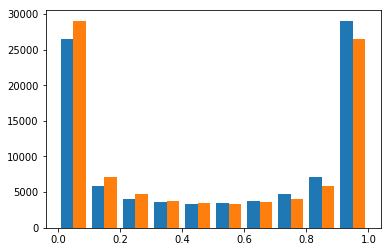

In [23]:
import matplotlib.pyplot as plt
plt.hist(p_prob)

array([[-6.32455515e+00, -1.79337026e-03],
       [-4.53024319e-01, -1.00978492e+00],
       [-6.09223298e-03, -5.10378517e+00],
       ...,
       [-2.45106534e+00, -9.01454141e-02],
       [-1.87752104e+00, -1.66017796e-01],
       [-5.51652012e+00, -4.02791326e-03]])

In [31]:
p_prob = cls.predict_proba(unlabeled.X)
prob_th = 0.95
assert(np.all(np.max(cls.predict_proba(unlabeled.X[np.max(p_prob, axis=1) > prob_th]), axis=1)>prob_th))

In [35]:
from scipy import sparse
# unlabeled.X[np.max(p_prob, axis=1) > prob_th]
sparse.vstack(unlabeled.X[np.max(p_prob, axis=1) > prob_th], sentiment.trainX)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''